<a href="https://colab.research.google.com/github/ArtBreguez/ArtBreguez/blob/main/XGBNQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
### 📦 Instalar dependências
!pip install pandas scikit-learn matplotlib ta xgboost openpyxl --quiet


In [84]:
### 📁 Carregar os dados
import pandas as pd

df = pd.read_excel('/content/mnq-s15-last-2024-12-29-2025-05-04.xlsx')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)


In [85]:
df

,timestamp,open,high,low,close
0,2024-12-29 18:00:00-05:00,21710.75,21736.00,21707.25,21732.50
1,2024-12-29 18:00:15-05:00,21732.50,21742.50,21729.00,21737.50
2,2024-12-29 18:00:30-05:00,21737.00,21741.75,21736.75,21739.25
3,2024-12-29 18:00:45-05:00,21738.50,21742.50,21734.25,21735.50
4,2024-12-29 18:01:00-05:00,21734.50,21740.00,21734.00,21736.50
...,...,...,...,...,...
725995,2025-05-04 19:58:45-04:00,20084.25,20084.25,20081.50,20082.00
725996,2025-05-04 19:59:00-04:00,20081.75,20084.00,20080.50,20083.50
725997,2025-05-04 19:59:15-04:00,20083.25,20084.50,20081.75,20083.25
725998,2025-05-04 19:59:30-04:00,20083.50,20083.75,20082.25,20082.50


In [120]:
# Garantir que 'timestamp' está no formato datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])

# Fazer o resample sem considerar 'volume'
df = df.set_index('timestamp').resample('1min').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
}).dropna().reset_index()


In [121]:
# 3. 🧮 Criar Features Técnicas (base inicial)

import ta

df['ema_20'] = ta.trend.ema_indicator(df['close'], window=20)
df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
df['macd'] = ta.trend.macd_diff(df['close'])
df['atr_14'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14)
df['adx'] = ta.trend.adx(df['high'], df['low'], df['close'], window=14)

df['ret_15s'] = df['close'].pct_change()
df['volatility'] = df['ret_15s'].rolling(window=20).std()

df['body'] = (df['close'] - df['open']).abs()
df['upper_shadow'] = df['high'] - df[['close', 'open']].max(axis=1)
df['lower_shadow'] = df[['close', 'open']].min(axis=1) - df['low']

# Features extras (para testar incrementos)
df['roc'] = ta.momentum.ROCIndicator(df['close'], window=5).roc()
df['cci'] = ta.trend.cci(df['high'], df['low'], df['close'], window=14)
df['willr'] = ta.momentum.WilliamsRIndicator(df['high'], df['low'], df['close'], lbp=14).williams_r()

df['sma_50'] = ta.trend.sma_indicator(df['close'], window=50)
df['sma_60'] = ta.trend.sma_indicator(df['close'], window=60)
df['trend_strength'] = df['ema_20'] / df['sma_50'] - 1
df['trend_5min'] = df['sma_50'] / df['sma_60'] - 1

df['bullish_engulfing'] = (
    (df['close'] > df['open']) &
    (df['open'].shift(1) > df['close'].shift(1)) &
    (df['close'] > df['open'].shift(1))
).astype(int)


In [122]:
# 4. 🎯 Criar Target (horizonte maior para retorno futuro)

df['future_return'] = df['close'].shift(-3) / df['close'] - 1  # 5 candles à frente
df['target'] = (df['future_return'] > 0).astype(int)
df = df.dropna().reset_index(drop=True)


In [123]:
# 5. ✂️ Dividir dados e normalizar (teste com base inicial ou incremental)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Escolha o conjunto de features para testar:
features_base = [
    'ema_20', 'rsi', 'macd', 'atr_14', 'adx',
    'ret_15s', 'volatility',
    'body', 'upper_shadow', 'lower_shadow'
]

features_roc = features_base + ['roc']
features_cci = features_roc + ['cci']
features_willr = features_cci + ['willr']

# Troque aqui para testar os diferentes conjuntos
features = features_base

X = df[features]
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle=False, test_size=0.2)


In [124]:
# 6. 🤖 Treinar modelo XGBoost com parâmetros conservadores

from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    min_child_weight=10,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [125]:
# 7. 🧠 Previsões e cálculos com custo de transação opcional

proba = model.predict_proba(X_test)[:, 1]
df_test = df.iloc[len(X_train):].copy()
df_test['proba'] = proba

threshold = 0.75  # ajuste para testar diferentes valores

df_test['prediction'] = (df_test['proba'] > threshold).astype(int)

transaction_cost = 0.0006  # custo por trade

df_test['strategy_return'] = df_test['prediction'].shift(1) * df_test['future_return']
df_test['cost'] = df_test['prediction'].shift(1) * transaction_cost

# Retorno líquido descontando custo de transação
df_test['net_strategy_return'] = df_test['strategy_return'] - df_test['cost']

df_test['buy_hold'] = df_test['future_return']

# Cumulativo bruto e líquido
df_test['ml_gross_cum'] = (1 + df_test['strategy_return']).cumprod()
df_test['ml_net_cum'] = (1 + df_test['net_strategy_return']).cumprod()
df_test['buy_hold_cum'] = (1 + df_test['buy_hold']).cumprod()


In [126]:
# 8. 📈 Métricas descritivas com e sem custo

final_ml_gross = df_test['ml_gross_cum'].iloc[-1]
final_ml_net = df_test['ml_net_cum'].iloc[-1]
final_bh = df_test['buy_hold_cum'].iloc[-1]

ml_gross_returns = df_test['strategy_return']
ml_net_returns = df_test['net_strategy_return']
bh_returns = df_test['buy_hold']

ml_gross_sharpe = ml_gross_returns.mean() / ml_gross_returns.std()
ml_net_sharpe = ml_net_returns.mean() / ml_net_returns.std()
bh_sharpe = bh_returns.mean() / bh_returns.std()

num_trades = df_test['prediction'].sum()
total_cost_pct = df_test['cost'].sum() * 100
avg_return_per_trade = ml_net_returns[ml_net_returns != 0].mean()

print(f"📈 Retorno final ML (bruto):       {final_ml_gross:.4f}x")
print(f"📌 Retorno final ML (líquido):     {final_ml_net:.4f}x")
print(f"📌 Retorno final Buy & Hold:        {final_bh:.4f}x")
print(f"📈 Retorno % ML (bruto):            {(final_ml_gross - 1)*100:.2f}%")
print(f"📈 Retorno % ML (líquido):          {(final_ml_net - 1)*100:.2f}%")
print(f"📉 Retorno % Buy & Hold:            {(final_bh - 1)*100:.2f}%")
print(f"🧠 Sharpe ML (bruto):               {ml_gross_sharpe:.2f}")
print(f"🧠 Sharpe ML (líquido):             {ml_net_sharpe:.2f}")
print(f"📊 Sharpe Buy & Hold:               {bh_sharpe:.2f}")
print(f"💸 Custo total em %:                {total_cost_pct:.4f}%")
print(f"🔁 Número de trades realizados:     {num_trades}")
print(f"📉 Retorno médio por trade (líquido): {avg_return_per_trade:.6f}")


📈 Retorno final ML (bruto):       1.0255x
📌 Retorno final ML (líquido):     1.0182x
📌 Retorno final Buy & Hold:        0.7984x
📈 Retorno % ML (bruto):            2.55%
📈 Retorno % ML (líquido):          1.82%
📉 Retorno % Buy & Hold:            -20.16%
🧠 Sharpe ML (bruto):               0.02
🧠 Sharpe ML (líquido):             0.02
📊 Sharpe Buy & Hold:               -0.02
💸 Custo total em %:                0.7200%
🔁 Número de trades realizados:     12
📉 Retorno médio por trade (líquido): 0.001506


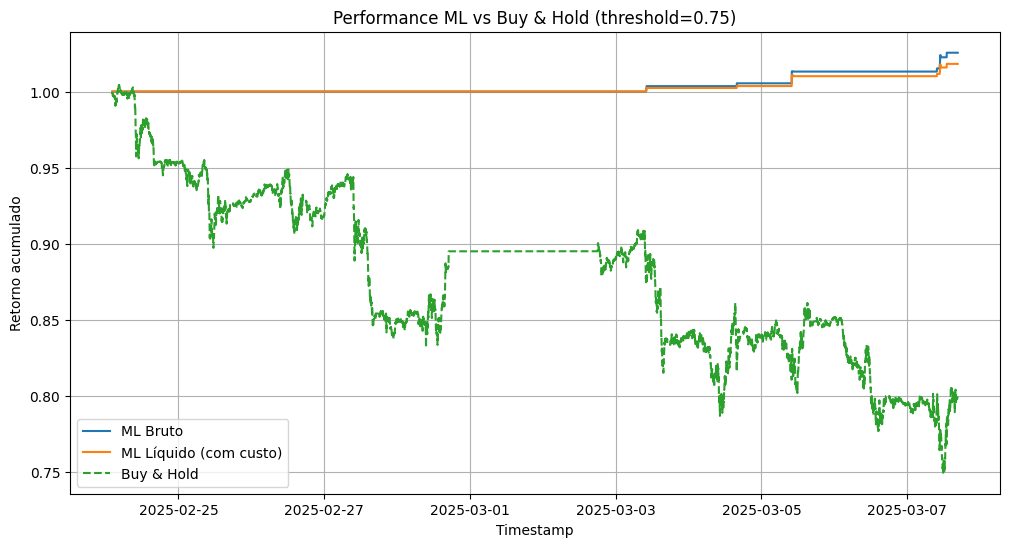

In [127]:
# 9. 📊 Gráfico com e sem custo de transação

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_test['timestamp'], df_test['ml_gross_cum'], label='ML Bruto')
plt.plot(df_test['timestamp'], df_test['ml_net_cum'], label='ML Líquido (com custo)')
plt.plot(df_test['timestamp'], df_test['buy_hold_cum'], label='Buy & Hold', linestyle='--')
plt.title(f"Performance ML vs Buy & Hold (threshold={threshold})")
plt.xlabel('Timestamp')
plt.ylabel('Retorno acumulado')
plt.legend()
plt.grid()
plt.show()
